## Gerekli Kütüphanelerin Dahil Edilmesi

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import cv2 as cv
from imutils import paths
import shutil

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input

from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, NASNetMobile, DenseNet121, ResNet50

C:\Users\berka\anaconda3\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## 1) Veri Hazırlama ve Analiz

<p>Bu aşamada toplanan görseller metadata.csv dosyasında bulunan etiket değerlerine göre klasörlere ayrılarak etiketlenmiştir. Daha sonra ise bu görsellerin sınıf bazlı bulanıklık analizi, parlaklık ve kontrast analizi  yapılmıştır. Bu analizlerden sonra görseller üzerinde çeşitli ön işleme (saç/kıl kaldırma, siyah çerçeve kaldırma, kontrast normalizasyonu (CLAHE) ve standartlaştırma) adımları uygulanmıştır. Ver ön işlemeden geçen görseller daha sonra ise okunmuştur.</p>

### 1.1) Toplanan verilerin (ISIC 2018) etiketlenmesi

In [2]:
# def move_images_by_label(csv_path, source_dir, target_dir, image_ext=".jpg"):
#     """
#     Verilen metadata CSV dosyasına göre, her görseli ait olduğu sınıf klasörüne taşır.

#     Args:
#         csv_path (str): metadata.csv dosyasının yolu.
#         source_dir (str): Görsellerin bulunduğu klasör.
#         target_dir (str): Görsellerin taşınacağı ana klasör.
#         image_ext (str): Görsel uzantısı (varsayılan: ".jpg")
#     """

#     # CSV dosyasını yükle
#     df = pd.read_csv(csv_path)

#     # Sınıf etiketleri
#     class_labels = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

#     # Ana hedef klasörü oluştur
#     os.makedirs(target_dir, exist_ok=True)

#     moved = 0
#     for _, row in df.iterrows():
#         image_id = row["image"]
#         for label in class_labels:
#             if row[label] == 1.0:
#                 src_file = os.path.join(source_dir, image_id + image_ext)
#                 dest_dir = os.path.join(target_dir, label)
#                 os.makedirs(dest_dir, exist_ok=True)
#                 dest_file = os.path.join(dest_dir, image_id + image_ext)
#                 if os.path.exists(src_file):
#                     shutil.copy2(src_file, dest_file)
#                     moved += 1
#                 else:
#                     print(f"Dosya bulunamadı: {src_file}")
#                 break  # Her görsel yalnızca bir sınıfa aittir.
#     print(f"Toplam {moved} görsel taşındı.")

In [3]:
# move_images_by_label("ISIC2018_Train_3/metadata.csv", "ISIC2018_Train_3/images/", "train_3")

In [4]:
# move_images_by_label("ISIC2018_Validation_3/metadata.csv", "ISIC2018_Validation_3/images/", "validation_3")

In [5]:
# move_images_by_label("ISIC2018_Test_3/metadata.csv", "ISIC2018_Test_3/images/", "test_3")

### 1.2) Veri Analizi

#### 1.2.1) Sınıf Dağılımı

In [6]:
# Sınıf  Dağılımı
df1 = pd.read_csv("ISIC2018_Train_3/metadata.csv")
df2 = pd.read_csv("ISIC2018_Validation_3/metadata.csv")
df3 = pd.read_csv("ISIC2018_Test_3/metadata.csv")

In [7]:
# Sınıf etiketleri
class_labels = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [8]:
# Her sınıfın toplamını hesaplama
train_class_counts = df1[class_labels].sum().sort_values(ascending=False)

validation_class_counts = df2[class_labels].sum().sort_values(ascending=False)

test_class_counts = df3[class_labels].sum().sort_values(ascending=False)

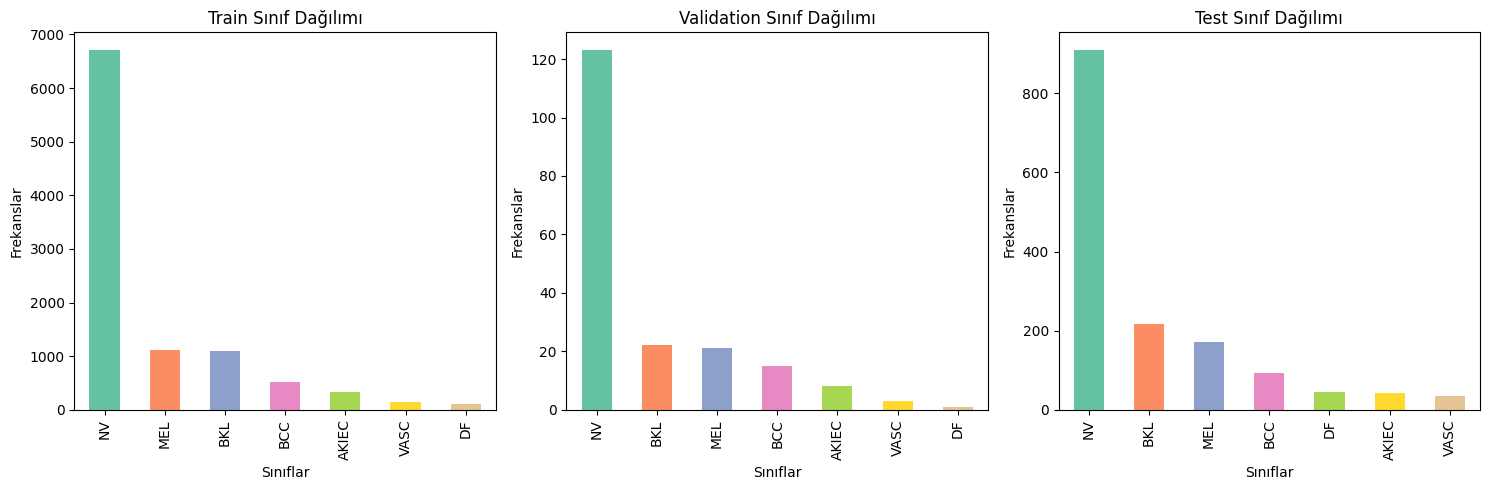

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

train_class_counts.plot(kind="bar", ax=axs[0], color=sns.color_palette("Set2"))
axs[0].set_title("Train Sınıf Dağılımı")
axs[0].set_xlabel("Sınıflar")
axs[0].set_ylabel("Frekanslar")

validation_class_counts.plot(kind="bar", ax=axs[1], color=sns.color_palette("Set2"))
axs[1].set_title("Validation Sınıf Dağılımı")
axs[1].set_xlabel("Sınıflar")
axs[1].set_ylabel("Frekanslar")

test_class_counts.plot(kind="bar", ax=axs[2], color=sns.color_palette("Set2"))
axs[2].set_title("Test Sınıf Dağılımı")
axs[2].set_xlabel("Sınıflar")
axs[2].set_ylabel("Frekanslar")

plt.tight_layout()
plt.show()

<p>Yukardaki görselden de anlaşılacağı gibi eğitim veri setimizde <b>sınıf dengesizliği (class imbalance)</b> problemi mevcut. Bu problem ilerleyen aşamalarda eğiteceğimiz modelin "Benign" sınıflarını (NV, BKL, VASC, DF) <b>ezberlemesine</b> ve "Malignant" sınıflarınında (MEL, BCC, AKIEC) ise <b>kötü performans</b> sergilemesine neden olabilir.</p>

Sınıf dengesizliği için yapılabilecekler:
1) <b>Veri Seviyesinde:</b>
   - <b>Undersampling:</b> Benign sınıfından rastgele örnek silme.
   - <b>Oversampling:</b> Malignant sınıfını çoğaltma.
   - <b>Veri arttırma (Data Augmentation):</b> Malignant sınıfına gerçek dünya özellikleri ekleme (döndürme, çevirme, yakınlaştırma gibi).

2) <b>Model Seviyesinde:</b>
   - <b>Class weights:</b> Kayıp fonksiyonuna sınıflara göre ağırlık vererek modeli dengelemek.
   - <b>Farklı metrik kullanımı:</b> Accuracy yerine F1-score, Recall gibi dengesiz veri setine uygun metrikler kullanmak.

#### 1.2.2) Diğer Önyargılar (Bias)

Potansiyel bias faktörleri:
- <b>Sınıf dengesizliği:</b> Model çoğunluk sınıfa yönelir.
- <b>Görüntü kalitesinde farklar:</b> Örneğin Malignant görseller daha bulanıksa ya da sınıflar arasında bariz bir kontrast farkı varsa model yanlış öğrenebilir.
- <b>Görüntü alma cihazları farklıysa:</b> Bazı görseller farklı hastanelerden geldiyse etiket dışı özellik öğrenilebilir.
- <b>Sınıflar arası görüntü yapısı farkı çok barizse:</b> Overfitting riski olabilir.

### 1.3) Veri Ön İşleme ve Okuma

In [19]:
from tqdm import tqdm

# Saç kaldırma fonksiyonu
def hair_removal(img):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (17, 17))
    blackhat = cv.morphologyEx(gray, cv.MORPH_BLACKHAT, kernel)
    _, mask = cv.threshold(blackhat, 10, 255, cv.THRESH_BINARY)
    mask = cv.dilate(mask, None)
    img = cv.inpaint(img, mask, 1, cv.INPAINT_TELEA)
    return img

# Siyah çerçeve kaldırma fonksiyonu
def remove_black_border(img, threshold=10):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    _, thresh = cv.threshold(gray, threshold, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv.contourArea)
        x, y, w, h = cv.boundingRect(cnt)
        img_cropped = img[y:y+h, x:x+w]
        return img_cropped
    else:
        return img

# CLAHE uygulaması
def apply_clahe(img):
    lab = cv.cvtColor(img, cv.COLOR_RGB2LAB)
    l, a, b = cv.split(lab)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    lab_clahe = cv.merge((cl,a,b))
    img_clahe = cv.cvtColor(lab_clahe, cv.COLOR_LAB2RGB)
    return img_clahe

# Standartlaştırma (ortalama 0, std 1)
def standardize(img):
    img = img.astype(np.float32) / 255.0  # Görseli [0, 1] aralığına çek
    mean = np.mean(img, axis=(0, 1), keepdims=True)  # Her kanal için ortalama
    std = np.std(img, axis=(0, 1), keepdims=True) + 1e-7  # Her kanal için std (0'a bölmeyi engellemek için epsilon)
    img_standard = (img - mean) / std
    return img_standard

In [20]:
import os
import cv2 as cv
import numpy as np
from sklearn.utils import shuffle
from imutils import paths
from tqdm import tqdm

def load_datasets(image_path, labels_map, size=(128,128)):
    labels = []
    x = []

    image_paths = sorted(list(paths.list_images(image_path)))
    
    for image_path in tqdm(image_paths, desc="Processing"):
        img = cv.imread(image_path)
        if img is None:
            continue

        # Renk dönüşümü
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        # Ön işleme
        img = hair_removal(img)
        img = remove_black_border(img)

        # Resize işlemi
        img = cv.resize(img, size)

        img = apply_clahe(img)
        img = standardize(img)

        x.append(img)

        label = os.path.basename(os.path.dirname(image_path))
        labels.append(labels_map[label])

    x, labels = shuffle(x, labels, random_state=42)

    print(f"X boyutu: {np.array(x).shape}")
    print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

    return x, labels

In [21]:
train_path = "train_3/"
val_path = "validation_3/"
test_path = "test_3/"

labels_map = {'MEL': 0, 
              'NV': 1, 
              'BCC': 2, 
              'AKIEC': 3, 
              'BKL': 4, 
              'DF': 5, 
              'VASC': 6}

size = (128, 128)

In [22]:
train_x, train_labels = load_datasets(train_path, labels_map, size)

Processing: 100%|████████████████████████████████████████████████████████████████| 10015/10015 [11:51<00:00, 14.08it/s]


X boyutu: (10015, 128, 128, 3)
Label sınıf sayısı: 7 Gözlem sayısı: 10015


In [23]:
val_x, val_labels = load_datasets(val_path, labels_map, size)

Processing: 100%|████████████████████████████████████████████████████████████████████| 193/193 [00:13<00:00, 14.50it/s]

X boyutu: (193, 128, 128, 3)
Label sınıf sayısı: 7 Gözlem sayısı: 193


In [24]:
test_x, test_labels = load_datasets(test_path, labels_map, size)

Processing: 100%|██████████████████████████████████████████████████████████████████| 1512/1512 [01:48<00:00, 13.95it/s]


X boyutu: (1512, 128, 128, 3)
Label sınıf sayısı: 7 Gözlem sayısı: 1512


In [25]:
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

In [26]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

#### 1.3.1) Veri Setinden Örnek Görüntüler

In [33]:
numbers_map = {v:k for (k, v) in labels_map.items()}
numbers_map

{0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AKIEC', 4: 'BKL', 5: 'DF', 6: 'VASC'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.4044876..3.434381].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.270907..3.8947248].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.1307883..2.5397727].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.271365..3.8166335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.0011272..2.5797255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.8180733..1.7154853].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.6129823..

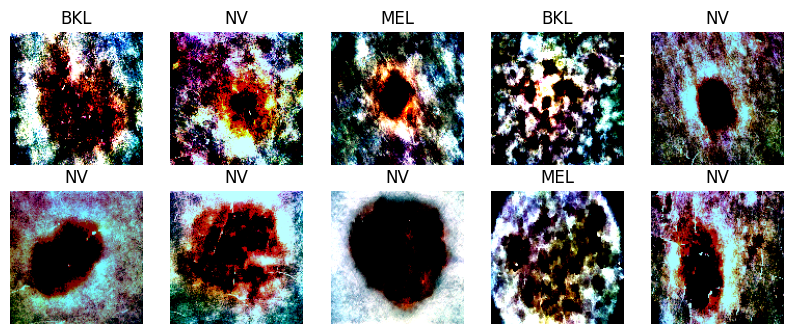

In [34]:
plt.figure(figsize=(10, 10))
for i in range(0, 10):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(numbers_map[train_labels[i]])
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.4044876..3.434381].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11.445782..3.7816758].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6918242..2.0542486].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.3640275..2.9401844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.68..1.8512969].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.0674143..3.6347883].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.8978715..1.5

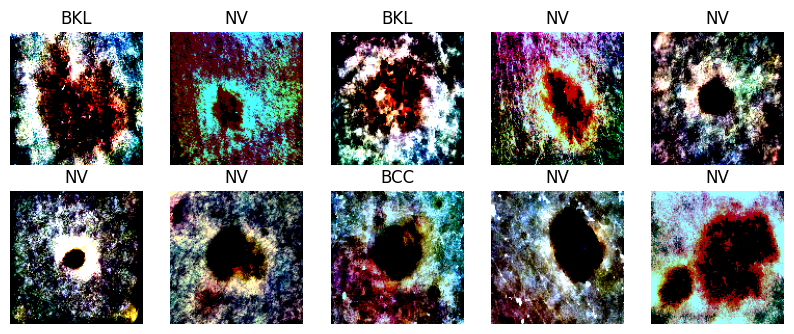

In [35]:
plt.figure(figsize=(10, 10))
for i in range(0, 10):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(train_x[-i])
    plt.title(numbers_map[train_labels[-i]])
    plt.axis("off")

In [36]:
train_labels = to_categorical(train_labels, num_classes=7)
val_labels = to_categorical(val_labels, num_classes=7)
test_labels = to_categorical(test_labels, num_classes=7)

In [37]:
train_labels_int = np.argmax(train_labels, axis=1)

## 2) Model Geliştirme ve Eğitim

### 2.1) Model Seçimi

<p>Bu aşamada, 128×128 boyutlarına ölçeklenmiş görüntüler üzerinde çalışabilecek farklı transfer learning modelleri karşılaştırılmıştır. Karşılaştırma, modellerin doğrulama setindeki kayıp (loss) ve sınıflara özgü performans metrikleri (örneğin accuracy, precision, recall) üzerinden gerçekleştirilmiştir. Seçilen modeller, tıbbi görüntü sınıflandırma literatüründe yaygın olarak kullanılan ve düşük giriş çözünürlüğünde dahi güçlü performans gösteren mimarilerden oluşmaktadır. Bunlar arasında MobileNetV2, EfficientNetB0, ResNet50, ve DenseNet121 gibi modeller bulunmaktadır. 

Modeller, aynı eğitim ve validasyon verisi ile eğitilmiş ve karşılaştırmanın adil olması için hiperparametreler (optimizer, öğrenme oranı, batch size vb.) sabit tutulmuştur. En uygun model, doğrulama setinde en düşük kayıp değerini veren ve aynı zamanda azınlık sınıflarda tatmin edici performans sergileyen model olarak seçilmiştir. Daha sonra ise seçilen modelin classification report bilgilerine bakılıp, ROC-AUC ve confusion matrix görselleştirmeleri yapılmıştır.</p>

<b>NOT:</b>Sınıf dengesizliği için maskeleme, veri arttırırmı, class weight, focal loss ve dışarıdan görsel ekleme gibi teknikler denenmiştir. Ancak bu teknikler yeteri kadar başarılı olamamıştır.

### 2.1.1) Base CNN Model

In [38]:
# Giriş katmanı
input_layer = Input(shape=(128, 128, 3))

# Konvolüsyonel ve MaxPooling katmanları
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x)

# Tam bağlantılı katmanlar
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

# Çıkış katmanı
output_layer = Dense(7, activation='softmax')(x)

# Modeli oluştur
model1 = Model(inputs=input_layer, outputs=output_layer)

In [39]:
model1.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy', 
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.F1Score(name="f1-score")])

In [40]:
callbacks = [EarlyStopping(monitor="val_loss", 
                           patience=7, 
                           mode="min",
                           min_delta=0.001,
                           verbose=1,
                           restore_best_weights=True), 
             ReduceLROnPlateau(monitor='val_loss', 
                               factor=0.5, 
                               patience=2)]

In [41]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_int),
    y=train_labels_int
)

In [42]:
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.2854575792581184,
 1: 0.21338020666879728,
 2: 2.78349082823791,
 3: 4.375273044997815,
 4: 1.301832835044846,
 5: 12.440993788819876,
 6: 10.075452716297788}

In [44]:
history1 = model1.fit(train_x, 
                      train_labels, 
                      epochs=20, 
                      callbacks=callbacks,
                      validation_data=(val_x, val_labels), 
                      class_weight=class_weights)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 98s 313ms/step - accuracy: 0.1554 - f1-score: 0.0835 - loss: 1.9369 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0155 - val_f1-score: 0.0044 - val_loss: 1.9591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 99s 318ms/step - accuracy: 0.1093 - f1-score: 0.0843 - loss: 1.9343 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0777 - val_f1-score: 0.0206 - val_loss: 2.0299 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 101s 322ms/step - accuracy: 0.0788 - f1-score: 0.0712 - loss: 2.0117 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4352 - val_f1-score: 0.1073 - val_loss: 1.9105 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 105s 335ms/step - accuracy: 0.1613 - f1-score: 0.1103 - loss: 1.9800 - pre

### 2.1.2) EfficientNetB0 Modeli

In [51]:
efficient_model = EfficientNetB0(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
efficient_model.trainable = False

x = efficient_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.20)(x)
output = Dense(7, activation='softmax')(x)

model2 = Model(inputs=efficient_model.input, outputs=output)

In [52]:
model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy', 
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.F1Score(name="f1-score")])

In [53]:
history2 = model2.fit(train_x, 
                     train_labels, 
                     epochs=20, 
                     callbacks=callbacks, 
                     validation_data=(val_x, val_labels), 
                     class_weight=class_weights)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 109s 306ms/step - accuracy: 0.2757 - f1-score: 0.1638 - loss: 2.5679 - precision: 0.2991 - recall: 0.1519 - val_accuracy: 0.3834 - val_f1-score: 0.2731 - val_loss: 1.6470 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 308ms/step - accuracy: 0.2866 - f1-score: 0.1856 - loss: 2.1669 - precision: 0.3449 - recall: 0.1617 - val_accuracy: 0.3575 - val_f1-score: 0.2491 - val_loss: 1.6387 - val_precision: 0.5000 - val_recall: 0.0259 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 309ms/step - accuracy: 0.3095 - f1-score: 0.1871 - loss: 1.8473 - precision: 0.4137 - recall: 0.1497 - val_accuracy: 0.3575 - val_f1-score: 0.2093 - val_loss: 1.6241 - val_precision: 0.4286 - val_recall: 0.0933 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 103s 330ms/step - accuracy: 0.3110 - f1-score: 0.2216 - loss: 1.7831 - precision: 0.4138 - recall: 0.1281 - val_ac

### 2.1.3) MobileNetV2 Modeli

In [54]:
mobilenet_model = MobileNetV2(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
mobilenet_model.trainable = False

x = mobilenet_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.20)(x)
output = Dense(7, activation='softmax')(x)

model3 = Model(inputs=mobilenet_model.input, outputs=output)

In [55]:
model3.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy', 
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.F1Score(name="f1-score")])

In [56]:
history3 = model3.fit(train_x, 
                     train_labels, 
                     epochs=20, 
                     callbacks=callbacks, 
                     validation_data=(val_x, val_labels), 
                     class_weight=class_weights)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 237ms/step - accuracy: 0.3575 - f1-score: 0.2190 - loss: 2.0566 - precision: 0.4182 - recall: 0.2725 - val_accuracy: 0.3782 - val_f1-score: 0.2378 - val_loss: 1.6999 - val_precision: 0.4508 - val_recall: 0.2850 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 75s 240ms/step - accuracy: 0.4965 - f1-score: 0.3598 - loss: 1.1754 - precision: 0.5805 - recall: 0.4157 - val_accuracy: 0.6580 - val_f1-score: 0.4319 - val_loss: 0.9656 - val_precision: 0.7609 - val_recall: 0.5440 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 234ms/step - accuracy: 0.6072 - f1-score: 0.4564 - loss: 0.8629 - precision: 0.6874 - recall: 0.5161 - val_accuracy: 0.6321 - val_f1-score: 0.3941 - val_loss: 1.0982 - val_precision: 0.6944 - val_recall: 0.5181 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 75s 240ms/step - accuracy: 0.6603 - f1-score: 0.5252 - loss: 0.6962 - precision: 0.7354 - recall: 0.5891 - val_accuracy: 0.

### 2.1.5) NASNetMobile Modeli

In [57]:
nasnet_model = NASNetMobile(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
nasnet_model.trainable = False

x = nasnet_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.20)(x)
output = Dense(7, activation='softmax')(x)

model4 = Model(inputs=nasnet_model.input, outputs=output)

In [58]:
model4.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy', 
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.F1Score(name="f1-score")])

In [59]:
history4 = model4.fit(train_x, 
                     train_labels, 
                     epochs=20, 
                     callbacks=callbacks, 
                     validation_data=(val_x, val_labels), 
                     class_weight=class_weights)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 360ms/step - accuracy: 0.2621 - f1-score: 0.1699 - loss: 2.7205 - precision: 0.2871 - recall: 0.1549 - val_accuracy: 0.3161 - val_f1-score: 0.1884 - val_loss: 2.0483 - val_precision: 0.3441 - val_recall: 0.1658 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 103s 330ms/step - accuracy: 0.3701 - f1-score: 0.2568 - loss: 1.5982 - precision: 0.4423 - recall: 0.2391 - val_accuracy: 0.2176 - val_f1-score: 0.1300 - val_loss: 1.8232 - val_precision: 0.3103 - val_recall: 0.1399 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 101s 322ms/step - accuracy: 0.4135 - f1-score: 0.3025 - loss: 1.3510 - precision: 0.4919 - recall: 0.2741 - val_accuracy: 0.3472 - val_f1-score: 0.2237 - val_loss: 1.6395 - val_precision: 0.3864 - val_recall: 0.1762 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 104s 333ms/step - accuracy: 0.4259 - f1-score: 0.3249 - loss: 1.2215 - precision: 0.5092 - recall: 0.2843 - val_accuracy

### 2.1.7) DenseNet121 Modeli

In [60]:
densenet_model = DenseNet121(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
densenet_model.trainable = False

x = densenet_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.20)(x)
x = Dense(128, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

model5 = Model(inputs=densenet_model.input, outputs=output)

In [61]:
model5.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy', 
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.F1Score(name="f1-score")])

In [62]:
history5 = model5.fit(train_x, 
                     train_labels, 
                     epochs=20, 
                     callbacks=callbacks, 
                     validation_data=(val_x, val_labels), 
                     class_weight=class_weights)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.4492 - f1-score: 0.2732 - loss: 1.6017 - precision: 0.6018 - recall: 0.2513 - val_accuracy: 0.6425 - val_f1-score: 0.3960 - val_loss: 1.0029 - val_precision: 0.8091 - val_recall: 0.4611 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.5998 - f1-score: 0.4468 - loss: 0.9847 - precision: 0.7124 - recall: 0.4936 - val_accuracy: 0.6736 - val_f1-score: 0.5347 - val_loss: 0.8585 - val_precision: 0.7754 - val_recall: 0.5544 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.6278 - f1-score: 0.4808 - loss: 0.8555 - precision: 0.7277 - recall: 0.5348 - val_accuracy: 0.6839 - val_f1-score: 0.5177 - val_loss: 0.9440 - val_precision: 0.7351 - val_recall: 0.5751 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.6678 - f1-score: 0.5460 - loss: 0.7052 - precision: 0.7485 - recall: 0.5887 - val_accuracy: 0.6218 - v

### 2.1.8) ResNet50 Modeli

In [63]:
resnet_model = ResNet50(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
resnet_model.trainable = False

x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.20)(x)
x = Dense(128, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

model6 = Model(inputs=resnet_model.input, outputs=output)

In [64]:
model6.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy', 
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.F1Score(name="f1-score")])

In [65]:
history6 = model6.fit(train_x, 
                     train_labels, 
                     epochs=20, 
                     callbacks=callbacks, 
                     validation_data=(val_x, val_labels), 
                     class_weight=class_weights)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.3342 - f1-score: 0.2032 - loss: 1.8695 - precision: 0.5152 - recall: 0.1046 - val_accuracy: 0.4352 - val_f1-score: 0.2386 - val_loss: 1.5273 - val_precision: 0.7778 - val_recall: 0.1088 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.4572 - f1-score: 0.3070 - loss: 1.3949 - precision: 0.6342 - recall: 0.2602 - val_accuracy: 0.4404 - val_f1-score: 0.2806 - val_loss: 1.4602 - val_precision: 0.6607 - val_recall: 0.1917 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.5090 - f1-score: 0.3691 - loss: 1.1082 - precision: 0.6567 - recall: 0.3425 - val_accuracy: 0.4249 - val_f1-score: 0.2332 - val_loss: 1.5163 - val_precision: 0.5474 - val_recall: 0.2694 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.5683 - f1-score: 0.4182 - loss: 0.9159 - precision: 0.6944 - recall: 0.4309 - val_accuracy: 0.4663 - v

In [66]:
histories = [history1,history2, history3, history4, history5, history6]

In [67]:
results = []

for idx, history in enumerate(histories):
    val_loss_list = history.history['val_loss']
    best_epoch = val_loss_list.index(min(val_loss_list))  # En düşük val_loss'un epoch'u

    # Diğer metrikleri o epoch'tan çek
    val_loss = val_loss_list[best_epoch]
    val_accuracy = history.history.get('val_accuracy', [None])[best_epoch]
    val_recall = history.history.get('val_recall', [None])[best_epoch]
    val_precision = history.history.get('val_precision', [None])[best_epoch]

    results.append({
        'Model': f'Model {idx+1}',
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'val_recall': val_recall,
        'val_precision': val_precision,
        'val_f1-score': 2*((val_precision * val_recall) / (val_recall + val_precision))
    })

df_results = pd.DataFrame(results)

In [68]:
df_results

,Model,val_loss,val_accuracy,val_recall,val_precision,val_f1-score
0,Model 1,1.180319,0.626943,0.217617,0.933333,0.352941
1,Model 2,1.263141,0.528497,0.181347,0.714286,0.289256
2,Model 3,0.868364,0.709845,0.626943,0.756250,0.685552
3,Model 4,1.175520,0.544041,0.466321,0.600000,0.524781
4,Model 5,0.643517,0.782383,0.735751,0.797753,0.765499
5,Model 6,1.343799,0.538860,0.476684,0.630137,0.542773


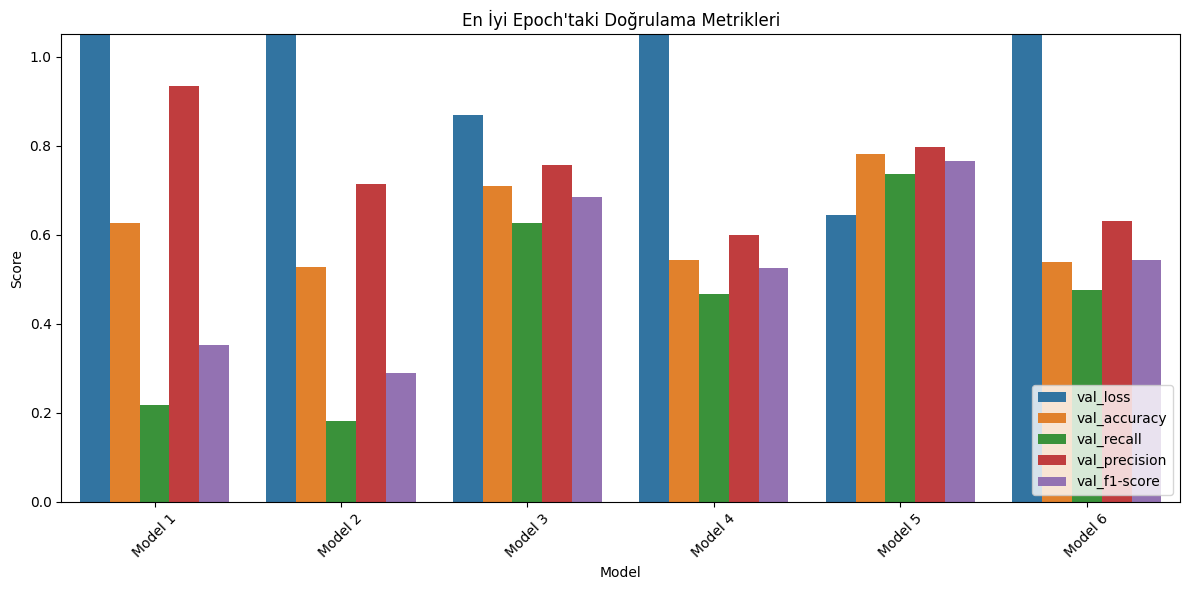

In [69]:
plt.figure(figsize=(12, 6))
df_melted = df_results.melt(id_vars='Model', var_name='Metric', value_name='Score')

sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted)
plt.title("En İyi Epoch'taki Doğrulama Metrikleri")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)  # normalize metrikler için
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

<p>Karşılaştırma yaptığımız modeller arasında en başarılı model Model5 yani DenseNet121 modeli olarak görünüyor. Bu nedenle test verisi ile görselleştirme yaparken DenseNet121 modelini kullanacağız.</p>

### 2.2) Test Verisi ile Model Değerlendirme

#### 2.2.1) Model 3 için Değerlendirme

In [70]:
test_score1 = model3.evaluate(x=test_x, y=test_labels)

48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.6087 - f1-score: 0.3862 - loss: 1.2063 - precision: 0.6782 - recall: 0.5595


In [71]:
print("Test Loss: ", test_score1[0])
print("Test Accuracy: ", test_score1[1])
print("Test Precision: ", test_score1[2])
print("Test Recall: ", test_score1[3])

Test Loss:  1.2494417428970337
Test Accuracy:  0.6025132536888123
Test Precision:  0.5542327761650085
Test Recall:  0.6634995937347412


In [86]:
y_true = []
y_pred_probs = []

# Model tahminlerini al
y_pred_probs = model3.predict(test_x)

# Gerçek etiketler
y_true = test_labels

# Eğer numpy array'e dönüştürme gerekiyorsa
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step


In [87]:
from sklearn.metrics import roc_curve, auc

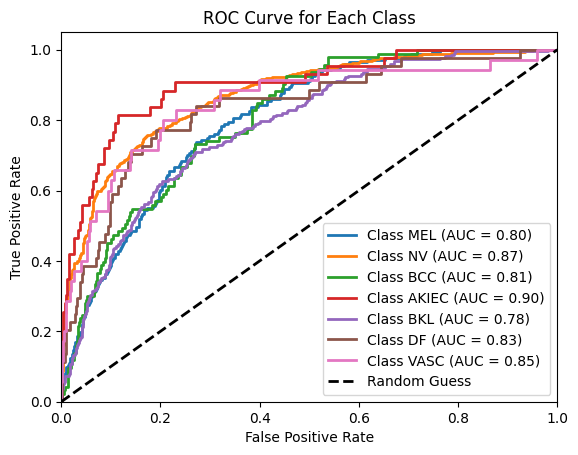

In [88]:
# Sınıf sayısını belirle
num_classes = y_true.shape[1]

# Her sınıf için ROC eğrisi ve AUC hesapla
for i in range(num_classes):
    # Gerçek etiketler ve tahmin olasılıkları
    y_true_class = y_true[:, i]
    y_pred_class = y_pred_probs[:, i]
    
    # ROC eğrisi ve AUC hesaplama
    fpr, tpr, thresholds = roc_curve(y_true_class, y_pred_class)
    roc_auc = auc(fpr, tpr)
    
    # ROC eğrisini çizme
    plt.plot(fpr, tpr, lw=2, label=f'Class {numbers_map[i]} (AUC = {roc_auc:.2f})')

# Rastgele tahmin çizgisi
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

# Grafik düzenleme
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

In [89]:
# Gerçek sınıfların ve tahmin edilen sınıfların belirlenmesi
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

In [90]:
labels = list(numbers_map.keys())

target_names = list(numbers_map.values())

print(classification_report(y_true_classes, y_pred_classes, labels=labels, target_names=target_names))

              precision    recall  f1-score   support

         MEL       0.32      0.50      0.39       171
          NV       0.86      0.74      0.79       909
         BCC       0.24      0.30      0.27        93
       AKIEC       0.30      0.49      0.37        43
         BKL       0.42      0.40      0.41       217
          DF       0.29      0.20      0.24        44
        VASC       0.24      0.29      0.26        35

    accuracy                           0.60      1512
   macro avg       0.38      0.42      0.39      1512
weighted avg       0.65      0.60      0.62      1512



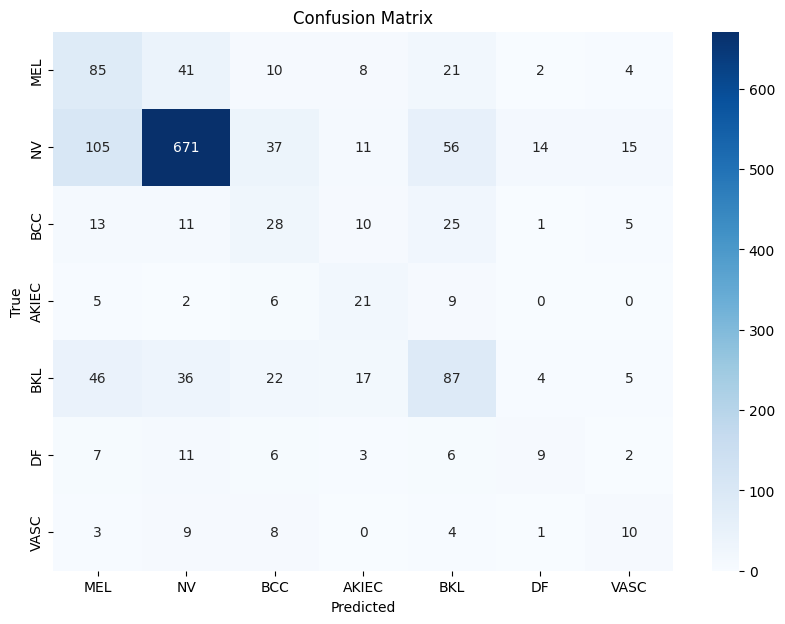

In [91]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', yticklabels=list(labels_map.keys()), xticklabels=list(labels_map.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [78]:
test_score2 = model5.evaluate(x=test_x, y=test_labels)

48/48 ━━━━━━━━━━━━━━━━━━━━ 35s 726ms/step - accuracy: 0.6506 - f1-score: 0.4850 - loss: 1.2216 - precision: 0.6796 - recall: 0.6134


In [79]:
print("Test Loss: ", test_score2[0])
print("Test Accuracy: ", test_score2[1])
print("Test Precision: ", test_score2[2])
print("Test Recall: ", test_score2[3])

Test Loss:  1.2211724519729614
Test Accuracy:  0.636904776096344
Test Precision:  0.6038359999656677
Test Recall:  0.667397677898407


In [81]:
y_true = []
y_pred_probs = []

# Model tahminlerini al
y_pred_probs = model5.predict(test_x)

# Gerçek etiketler
y_true = test_labels

# Eğer numpy array'e dönüştürme gerekiyorsa
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 855ms/step


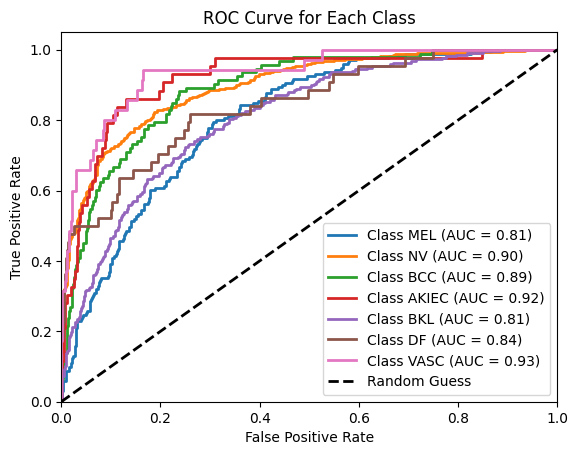

In [82]:
# Sınıf sayısını belirle
num_classes = y_true.shape[1]

# Her sınıf için ROC eğrisi ve AUC hesapla
for i in range(num_classes):
    # Gerçek etiketler ve tahmin olasılıkları
    y_true_class = y_true[:, i]
    y_pred_class = y_pred_probs[:, i]
    
    # ROC eğrisi ve AUC hesaplama
    fpr, tpr, thresholds = roc_curve(y_true_class, y_pred_class)
    roc_auc = auc(fpr, tpr)
    
    # ROC eğrisini çizme
    plt.plot(fpr, tpr, lw=2, label=f'Class {numbers_map[i]} (AUC = {roc_auc:.2f})')

# Rastgele tahmin çizgisi
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

# Grafik düzenleme
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

In [83]:
# Gerçek sınıfların ve tahmin edilen sınıfların belirlenmesi
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

In [84]:
labels = list(numbers_map.keys())

target_names = list(numbers_map.values())

print(classification_report(y_true_classes, y_pred_classes, labels=labels, target_names=target_names))

              precision    recall  f1-score   support

         MEL       0.30      0.50      0.38       171
          NV       0.89      0.76      0.82       909
         BCC       0.40      0.47      0.43        93
       AKIEC       0.27      0.44      0.33        43
         BKL       0.44      0.45      0.44       217
          DF       0.62      0.34      0.44        44
        VASC       0.45      0.40      0.42        35

    accuracy                           0.64      1512
   macro avg       0.48      0.48      0.47      1512
weighted avg       0.69      0.64      0.66      1512



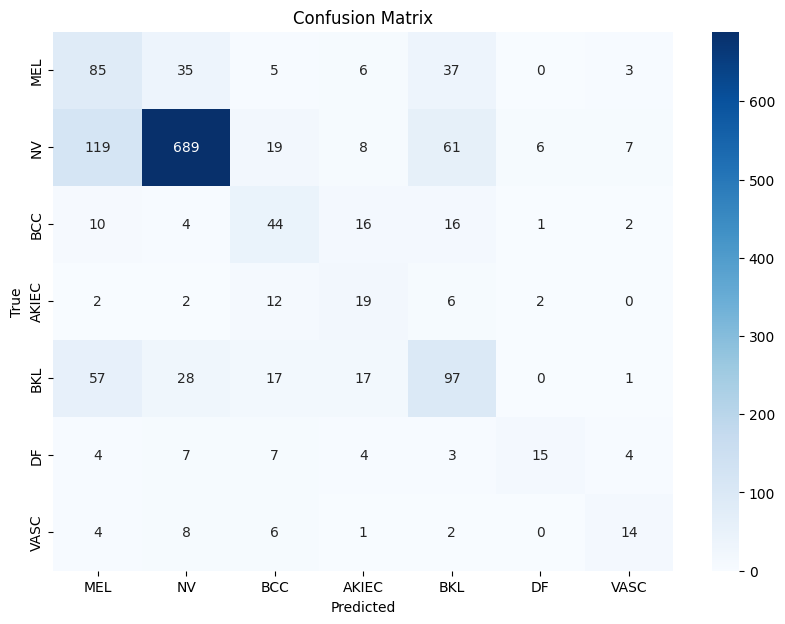

In [85]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', yticklabels=list(labels_map.keys()), xticklabels=list(labels_map.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [94]:
# model5.save("densenet121_66acc.keras")

### 2.2) Belirsizliğe Duyarlı Öğrenme

<p>Belirsizliğe duyarlı öğrenme (uncertainty-aware learning), makine öğrenmesi modellerinin güvenilmez (yani yüksek epistemik veya aleatorik belirsizlik içeren) kararlarına daha fazla dikkat ederek eğitilmesini amaçlayan bir yaklaşımdır. Bu tür öğrenme, modelin düşük güvenle tahmin yaptığı örnekleri tanımlayıp, bu örneklerin kayıp fonksiyonu içinde daha fazla ağırlıklandırılmasıyla gerçekleştirilir.

Özellikle dengesiz veri setlerinde, azınlık sınıflara ait örnekler hem daha az temsil edilir hem de genellikle model tarafından daha düşük olasılıklarla tahmin edilir. Bu durum belirsizlik oluşturur. Focal Loss bu bağlamda, modelin düşük olasılıkla tahmin ettiği yani belirsizliğin yüksek olduğu örneklerin kaybını artırarak, modelin bu örneklere odaklanmasını sağlar.

Bu bağlamda uygulanan yöntemler ve gerekçeleri:
- <b>Focal Loss Kullanımı:</b> Model, kolay örnekler yerine düşük olasılıkla tahmin ettiği zor örneklere odaklansın diye focal loss fonksiyonu kullanılmıştır. Bu sayede belirsizlik barındıran sınıfların öğrenme sürecine daha fazla katkı yapması sağlanmıştır.
- <b>Veri Artırımı (Data Augmentation):</b> Özellikle azınlık sınıfların varyasyonlarını artırarak, bu sınıfların daha genel özelliklerini öğrenmesini desteklemek ve belirsizlik kaynaklarını azaltmak amacıyla veri artırımı uygulanmıştır.</p>

### 2.3) Eğitim Stratejisi

<p>Modelin genellenebilirliğini artırmak, aşırı öğrenmeyi önlemek ve eğitim sürecini kararlı hale getirmek amacıyla çeşitli eğitim stratejileri uygulanmıştır:

- <b>Erken Durdurma (Early Stopping):</b> Eğitim sırasında doğrulama kaybının belirli bir sayıda epoch boyunca iyileşmemesi durumunda eğitimin otomatik olarak durdurulması için EarlyStopping geri callback'i kullanılmıştır. Bu yöntem, modelin eğitim verisine aşırı uyum sağlamasını (overfitting) önleyerek, en iyi doğrulama performansına sahip ağırlıkların korunmasını sağlar.
- <b>Öğrenme Oranın Ayarlanması (ReduceLROnPlateau):</b> Modelin doğrulama kaybı bir süre boyunca iyileşme göstermediğinde, öğrenme oranının azaltılması sağlanmıştır. Bu, modelin daha küçük adımlarla daha hassas bir şekilde minimum kayba ulaşmasına yardımcı olur.</p>

## 3) Model Yorumlanabilirliği

### 3.1) GridCAM Görselleştirmesi

In [100]:
def make_gradcam_heatmap_from_array(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [101]:
def prepare_heatmap(heatmap, target_size):
    heatmap = cv.resize(heatmap, target_size)
    return heatmap

In [110]:
import random

def show_gradcam_overlay(test_x, test_labels, model, last_conv_layer_name='conv5_block16_concat', class_names=None, alpha=0.4):
    idx = random.randint(0, len(test_x) - 1)
    image = test_x[idx]
    label = test_labels[idx]

    # Eğer one-hot encoded ise sınıf indeksini al
    if len(label.shape) > 0 and label.shape[-1] > 1:
        label_index = np.argmax(label)
    else:
        label_index = int(label)

    # Modele uygun şekle getir
    input_image = np.expand_dims(image, axis=0)

    # Grad-CAM heatmap hesapla
    heatmap = make_gradcam_heatmap_from_array(input_image, model, last_conv_layer_name)

    # Heatmap'i yeniden boyutlandır
    heatmap_resized = cv.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)

    # Jet renk haritası uygula
    heatmap_color = cv.applyColorMap(heatmap_uint8, cv.COLORMAP_JET)

    # Orijinal görüntü uint8 formatta olmalı
    if image.max() <= 1.0:
        image_uint8 = (image * 255).astype(np.uint8)
    else:
        image_uint8 = image.astype(np.uint8)

    # Overlay görüntü (üst üste bindirme)
    overlay = cv.addWeighted(image_uint8, 1 - alpha, heatmap_color, alpha, 0)

    # Görselleştir
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    label_name = class_names[label_index] if class_names else str(label_index)
    plt.title(f"Grad-CAM Overlay (Etiket: {label_name})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [111]:
test_labels_int = np.argmax(test_labels, axis=1)

C:\Users\berka\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_2206']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


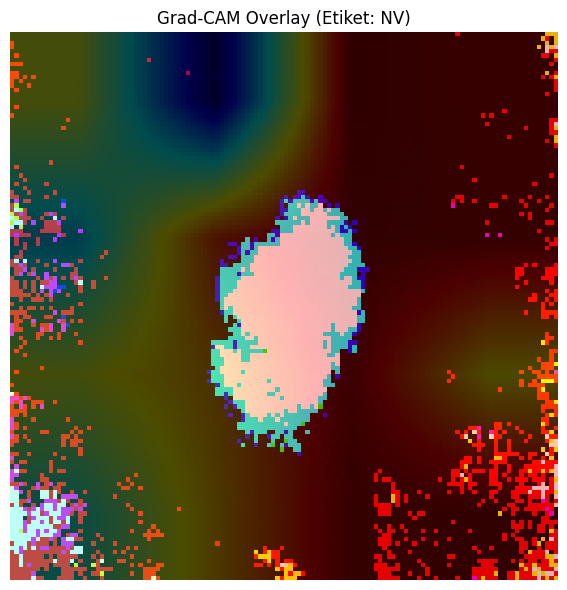

In [118]:
show_gradcam_overlay(test_x, test_labels_int, model5, class_names=class_labels, alpha=0.3)

### 3.2) Klinik Uygunluk

<p>Modelin karar verme sürecini yorumlayabilmek amacıyla Grad-CAM (Gradient-weighted Class Activation Mapping) yöntemiyle görselleştirme yapılmıştır. Bu görselleştirmeler, modelin hangi bölgelere odaklanarak karar verdiğini anlamaya olanak tanımış ve potansiyel bir karar destek aracı olarak değerlendirilmiştir. 

Grad-CAM çıktısında:
- Lezyonun tam merkezinin ve sınır bölgelerinin (özellikle üst ve alt kenarların) daha yoğun aktivasyonla vurgulandığı görülmektedir.
- Özellikle kenar bölgelerine yakın mavi-siyah geçişli alanlar, modelin sınır düzensizliklerine dikkat ettiğini göstermektedir.
- Modelin sınıflandırma yaparken doğrudan lezyon dışındaki (cilt arka planı) alana odaklanmadığı, bu da karar verme sürecinin klinik olarak anlamlı bölgelerle sınırlı kaldığını göstermektedir.

Klinik Değerlendirme Açısından Önemi:
- Lezyonun kenar yapılarının değerlendirilmesi, dermatolojik açıdan malignite ayırımı için önemlidir. Modelin bu bölgelerde yoğunlaşması, insan uzmanlar gibi morfolojik kriterlere dayalı karar verdiğini göstermektedir.
- Özellikle homojen iç yapı, belirgin sınırlılık, ve düzgün kontur gibi özellikler benign nevüslerde sık görülür. Bu görselde de modelin, bu tarz bir düzenliliği ayırt etmek üzere eğitildiği anlaşılmaktadır.</p>

## 4) Performans Değerlendirme

### 4.1) Metrik Seçimi

<p>Tıbbi teşhis problemlerinde değerlendirme metriklerinin seçimi, yalnızca genel doğruluğun değil, azınlık sınıflar üzerindeki performansın da dikkate alınması gerektiği bir yapıda gerçekleştirilmelidir. Bu nedenle, aşağıdaki metrikler kullanılmıştır:

- <b>Doğruluk (Accuracy):</b> Genel başarıyı ölçmek için kullanılmıştır. Ancak sınıf dağılımı dengesiz olduğunda yanıltıcı olabileceği için tek başına değerlendirilmemiştir.

- <b>Hassasiyet (Recall):</b> Özellikle hatalı bir şekilde “hastalığı yok” demenin riskli olduğu tıbbi senaryolarda kritik bir metriktir. Modelin gerçek pozitifleri ne kadar iyi yakalayabildiğini ölçer.

- <b>Kesinlik (Precision):</b> Modelin pozitif sınıf tahminlerinin ne kadarının doğru olduğunu gösterir. Yanlış pozitiflerin azaltılması gereken durumlarda önemlidir.

- <b>F1 Skoru:</b> Precision ve recall arasındaki dengeyi ölçerek, dengesiz veri kümeleri üzerinde daha adil bir genel performans ölçütü sağlar. Özellikle malign sınıf gibi azınlık sınıflar için kritik bir metriktir.
</p>

### 4.2) Değerlendirme Sonuçları

<p>En düşük doğrulama kaybına (validation loss) sahip modelin değerlendirmesi aşağıdaki şekilde yapılmıştır:

- Classification Report: Modelin her sınıf için precision, recall, F1-score değerleri detaylı şekilde analiz edilmiştir. Bu sayede hangi sınıflarda güçlü veya zayıf olduğu gözlemlenmiştir.
- ROC-AUC Eğrisi: Her sınıf için ROC (Receiver Operating Characteristic) eğrileri çizilmiş ve AUC (Area Under Curve) değerleri hesaplanmıştır. ROC-AUC skoru, sınıflar arasında ayırt edicilik düzeyini gösterir. Tıbbi sistemlerde yüksek ROC-AUC skorları, modelin güvenilirliğini artırır.
- Karışıklık Matrisi (Confusion Matrix): Modelin hangi sınıfları birbirine karıştırdığını gösteren görselleştirme ile birlikte analiz edilmiştir. Özellikle malign sınıfların hatalı sınıflandırıldığı örnekler dikkatle incelenmiştir.</p>

### 4.3) Hata Analizi

<p>Karmaşıklık Matrisi köşegenindeki değerler doğru sınıflandırmaları, diğerleri ise yanlış sınıflandırmaları göstermektedir. En yüksek doğru sınıflandırma oranı NV (Nevüs) sınıfında görülmektedir (689 doğru tahmin).

Melanom (MEL) ile İlgili Hatalar

<ol>
    <li>Yanlış negatifler: 35 MEL vakası NV olarak, 5'i BCC olarak yanlış sınıflandırılmış.</li>
    <li>Yanlış pozitifler: 119 NV vakası, 57 BKL vakası MEL olarak yanlış tahmin edilmiş.</li>
    <li>Örüntü: Model, melanomları özellikle nevüslerle (NV) ve bazal hücreli karsinomlarla (BCC) karıştırmaktadır.</li>
</ol>

Nevüs (NV) ile İlgili Hatalar

<ol>
    <li>Yanlış negatifler: 19 NV vakası BCC, 8'i AKIEC olarak yanlış sınıflandırılmış.</li>
    <li>Yanlış pozitifler: 35 MEL vakası NV olarak yanlış tahmin edilmiş.</li>
    <li>Örüntü: NV sınıfı genellikle iyi performans gösterse de, bazı melanomlar NV olarak yanlış sınıflandırılmaktadır.</li>
</ol>

Bazal Hücreli Karsinom (BCC) ile İlgili Hatalar

<ol>
    <li>Yanlış negatifler: 16 BCC vakası AKIEC, 16'sı BKL olarak yanlış sınıflandırılmış.</li>
    <li>Yanlış pozitifler: 5 MEL, 19 NV vakası BCC olarak yanlış tahmin edilmiş.</li>
    <li>Örüntü: BCC'ler sıklıkla aktinik keratoz (AKIEC) ve benign keratoz (BKL) ile karıştırılmaktadır.</li>
</ol>

Önemli Gözlemler

<ol>
    <li>Melanom ve Nevüs Karışıklığı: Modelin en kritik hatası, melanomları (MEL) nevüslerle (NV) karıştırmasıdır. Bu tıbbi açıdan ciddi sonuçlar doğurabilecek bir hatadır.</li>
    <li>BCC ve AKIEC/BKL Karışıklığı: BCC'lerin önemli bir kısmı diğer lezyon tipleriyle karıştırılmaktadır.</li>
</ol>

İyileştirme Önerileri

<ol>
    <li>Melanom-Nevüs Ayrımı: Modelin melanom ve nevüs ayrımını iyileştirmek için bu sınıflara özel özellik mühendisliği yapılabilir.</li>
    <li>Sınıf Dengesizliği: NV sınıfının baskın olduğu görülmektedir. Sınıf dengesizliğini gidermek için örnekleme teknikleri uygulanabilir.</li>
    <li>Veri Ekleme: Azınlık sınıflar için daha fazla eğitim verisi toplanabilir veya bu sınıfların ayırt edici özellikleri daha iyi tanımlanabilir.</li>
</ol>

Bu analiz, modelin özellikle melanom gibi kritik sınıflarda iyileştirmeye ihtiyaç duyduğunu göstermektedir. Yanlış negatiflerin (özellikle MEL için) tıbbi açıdan daha riskli olduğu düşünüldüğünde, modelin bu alandaki performansının artırılması öncelikli olmalıdır.</p>